<a href="https://colab.research.google.com/github/sbg0700/Larvathon1st/blob/main/Larvathon_PRJ_codebase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

제거된(누수 가능) 변수: ['HbA1c_any']
✅ Logit ROC-AUC: 0.754 | AP(PR-AUC): 0.223
✅ RF    ROC-AUC: 0.774 | AP(PR-AUC): 0.250

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.95      0.67      0.79      2069
           1       0.19      0.70      0.30       230

    accuracy                           0.68      2299
   macro avg       0.57      0.69      0.54      2299
weighted avg       0.88      0.68      0.74      2299

RandomForest Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      2069
           1       1.00      0.00      0.01       230

    accuracy                           0.90      2299
   macro avg       0.95      0.50      0.48      2299
weighted avg       0.91      0.90      0.85      2299



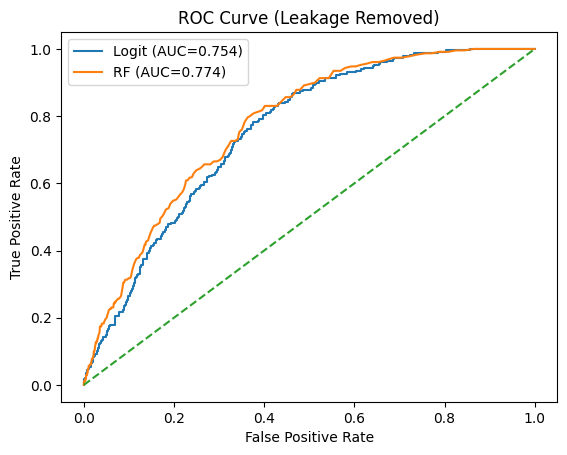

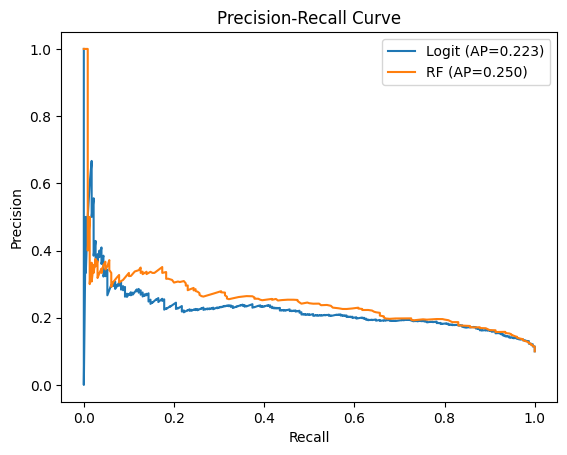

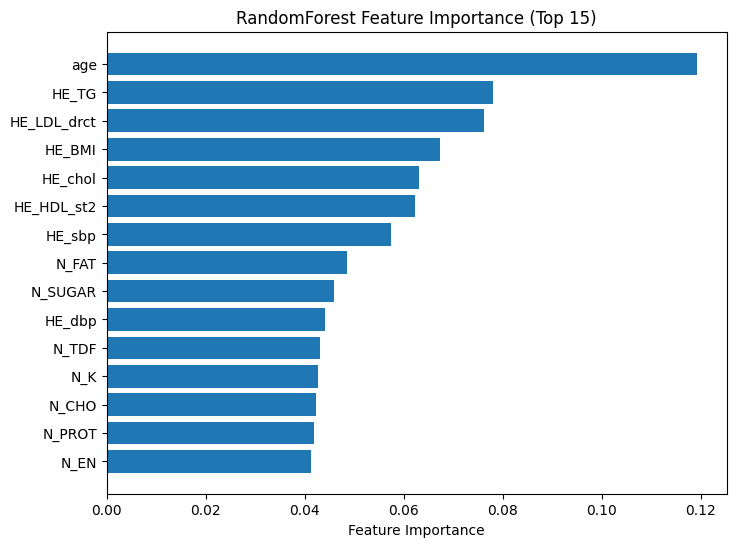

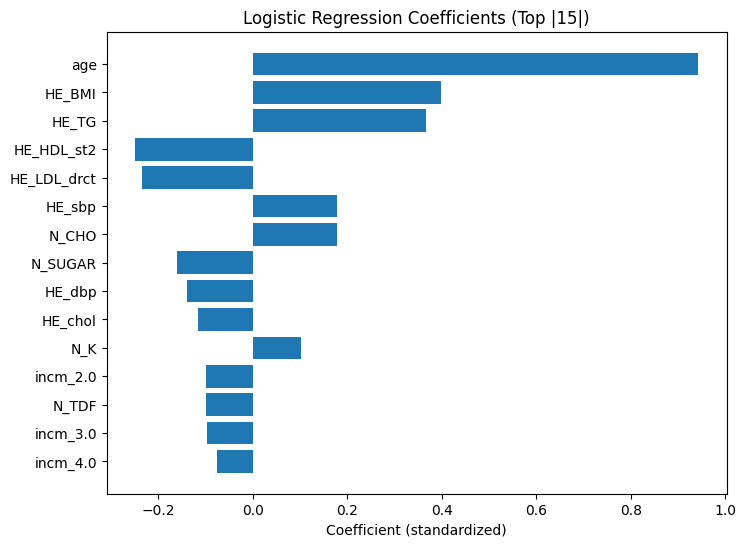


[해석 가이드]
- ROC-AUC 0.75~0.85: 의료 예측에서 현실적인 범위
- PR-AUC(AP)는 양성 적은 데이터에서 더 informative
- RF 중요도: '나이, BMI, TG, LDL, SBP, SUGAR' 등이 상위 → 임상적 타당성 점검
- Logit 계수 부호: +면 위험↑, -면 위험↓ (표준화 기준; 스케일 영향 제거)
- 운영 목적에 맞게 임계값 조정(0.5→0.4/0.6)으로 정밀도/재현율 트레이드오프 조절


In [1]:
# -*- coding: utf-8 -*-
"""
주제: 건강검진·영양섭취 데이터로 '당뇨 위험(0/1)' 예측 (이진 분류)
데이터: modeling_dataset_hba1c_Excel.csv (EUC-KR/CP949 인코딩)
타깃(y): '당뇨_위험' = 1 if HbA1c >= 6.5 else 0  (이미 CSV에 포함되어 있음)
중요: 입력 피처(X)에서는 HbA1c 관련 변수(HbA1c_any, HE_HbA1c 등)를 제거해 '데이터 누수(Leakage)'를 방지

모델:
 - Logistic Regression (해석 용이, 선형)
 - Random Forest (비선형 상호작용, 중요도 해석)

평가/시각화:
 - ROC-AUC, PR-AUC, 분류리포트(precision/recall/f1)
 - ROC 곡선(두 모델), PR 곡선(두 모델)
 - RF Feature Importance Top 15
 - Logit 계수(표준화 후 절댓값 Top 15, 방향성 포함)

사용 방법:
 1) 코랩에 이 셀을 그대로 실행
 2) '/content' 경로에 CSV 업로드 후 경로 확인
 3) 결과 수치와 그래프를 해석
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# -------------------------------------------------------------
# 1) 데이터 로드
#   - 엑셀 호환 저장(CP949/EUC-KR) 파일 가정
#   - 인코딩 이슈가 있으면 encoding='cp949' 또는 'euc-kr'로 시도
# -------------------------------------------------------------
DATA_PATH = '/content/modeling_dataset_hba1c_Excel.csv'
assert os.path.exists(DATA_PATH), f"CSV가 보이지 않습니다: {DATA_PATH} 에 업로드하세요."

df = pd.read_csv(DATA_PATH, encoding='cp949')  # 'euc-kr'도 동일

# -------------------------------------------------------------
# 2) 데이터 누수 방지: HbA1c 관련 열 제거
#   - 타깃 생성에 직접 쓰인 지표는 입력 피처에서 제거해야 함
#   - 예: 'HbA1c_any', 'HE_HbA1c', 'HE_DM_HbA1c' 등
# -------------------------------------------------------------
drop_cols = [c for c in df.columns if ('hba1c' in c.lower()) or ('_dm_' in c.lower())]
print("제거된(누수 가능) 변수:", drop_cols)
df = df.drop(columns=drop_cols, errors='ignore')

# -------------------------------------------------------------
# 3) 입력(X)/타깃(y) 분리
#   - y: '당뇨_위험' (0/1)
#   - X: 나머지 피처
# -------------------------------------------------------------
assert '당뇨_위험' in df.columns, "'당뇨_위험' 컬럼이 없습니다."
y = df['당뇨_위험'].astype(int)
X = df.drop(columns=['당뇨_위험'])

# -------------------------------------------------------------
# 4) 코드형(범주형)처럼 보이는 숫자열을 더미화(선택)
#   - 트리 모델은 더미화가 필수는 아니지만
#   - 로지스틱 회귀 계수 해석력 향상을 위해 권장
# -------------------------------------------------------------
code_like = [c for c in ['sex', 'educ', 'incm', 'occp'] if c in X.columns]
X = pd.get_dummies(X, columns=code_like, drop_first=True)

feature_names = X.columns.tolist()

# -------------------------------------------------------------
# 5) 데이터 분할 (층화: 양성/음성 비율 유지)
#   - 재현 가능성 확보를 위해 random_state 고정
# -------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -------------------------------------------------------------
# 6) 모델 구성
#   - LogisticRegression: 표준화 + class_weight='balanced' (불균형 보정)
#   - RandomForest: class_weight='balanced_subsample'
# -------------------------------------------------------------
logit = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced'))
])

rf = RandomForestClassifier(
    n_estimators=500, random_state=42, n_jobs=-1, class_weight='balanced_subsample'
)

# -------------------------------------------------------------
# 7) 학습
# -------------------------------------------------------------
logit.fit(X_train, y_train)
rf.fit(X_train, y_train)

# -------------------------------------------------------------
# 8) 예측 점수(확률) 및 평가지표
#   - ROC-AUC: 임계값 전반의 구분력
#   - PR-AUC(AP): 양성 비율이 낮을 때 더 직관적
#   - classification_report: precision/recall/f1
# -------------------------------------------------------------
proba_logit = logit.predict_proba(X_test)[:, 1]
proba_rf    = rf.predict_proba(X_test)[:, 1]

roc_auc_logit = roc_auc_score(y_test, proba_logit)
roc_auc_rf    = roc_auc_score(y_test, proba_rf)

prec_l, rec_l, _ = precision_recall_curve(y_test, proba_logit)
prec_r, rec_r, _ = precision_recall_curve(y_test, proba_rf)
ap_l = average_precision_score(y_test, proba_logit)
ap_r = average_precision_score(y_test, proba_rf)

print(f"✅ Logit ROC-AUC: {roc_auc_logit:.3f} | AP(PR-AUC): {ap_l:.3f}")
print(f"✅ RF    ROC-AUC: {roc_auc_rf:.3f} | AP(PR-AUC): {ap_r:.3f}\n")

print("Logistic Regression Report:\n", classification_report(y_test, logit.predict(X_test)))
print("RandomForest Report:\n", classification_report(y_test, rf.predict(X_test)))

# -------------------------------------------------------------
# 9) ROC 곡선 (두 모델 한 플롯)
#   - x: FPR(위양성률), y: TPR(재현율)
#   - 대각선: 랜덤 추정 기준선
# -------------------------------------------------------------
fpr_l, tpr_l, _ = roc_curve(y_test, proba_logit)
fpr_r, tpr_r, _ = roc_curve(y_test, proba_rf)

plt.figure()
plt.plot(fpr_l, tpr_l, label=f'Logit (AUC={roc_auc_logit:.3f})')
plt.plot(fpr_r, tpr_r, label=f'RF (AUC={roc_auc_rf:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Leakage Removed)')
plt.legend()
plt.show()

# -------------------------------------------------------------
# 10) Precision-Recall 곡선
#   - 양성 드문 데이터에서 모델 비교시 유용
# -------------------------------------------------------------
plt.figure()
plt.plot(rec_l, prec_l, label=f'Logit (AP={ap_l:.3f})')
plt.plot(rec_r, prec_r, label=f'RF (AP={ap_r:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# -------------------------------------------------------------
# 11) RandomForest Feature Importance (Top 15)
#   - 트리 분할에서의 평균 기여도(상대지표)
# -------------------------------------------------------------
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(8, 6))
plt.barh(range(len(idx)), importances[idx][::-1])
plt.yticks(range(len(idx)), [feature_names[i] for i in idx][::-1])
plt.xlabel('Feature Importance')
plt.title('RandomForest Feature Importance (Top 15)')
plt.show()

# -------------------------------------------------------------
# 12) Logistic Regression 계수 (Top |15|)
#   - 표준화된 계수 → 양(+)이면 위험 ↑, 음(-)이면 위험 ↓ 방향성
# -------------------------------------------------------------
coefs = logit.named_steps['clf'].coef_[0]
coef_idx = np.argsort(np.abs(coefs))[::-1][:15]

plt.figure(figsize=(8, 6))
plt.barh(range(len(coef_idx)), coefs[coef_idx][::-1])
plt.yticks(range(len(coef_idx)), [feature_names[i] for i in coef_idx][::-1])
plt.xlabel('Coefficient (standardized)')
plt.title('Logistic Regression Coefficients (Top |15|)')
plt.show()

# -------------------------------------------------------------
# 13) 간단 가이드라인 (출력용)
# -------------------------------------------------------------
print("\n[해석 가이드]")
print("- ROC-AUC 0.75~0.85: 의료 예측에서 현실적인 범위")
print("- PR-AUC(AP)는 양성 적은 데이터에서 더 informative")
print("- RF 중요도: '나이, BMI, TG, LDL, SBP, SUGAR' 등이 상위 → 임상적 타당성 점검")
print("- Logit 계수 부호: +면 위험↑, -면 위험↓ (표준화 기준; 스케일 영향 제거)")
print("- 운영 목적에 맞게 임계값 조정(0.5→0.4/0.6)으로 정밀도/재현율 트레이드오프 조절")
